# Project 2: Classification and Regression



Collaborators:
* Abhay Sharma
 * Classification Centroid/KNN Modeling and Analysis, Data Preperation, Regression Analysis and Comparison, Variable Importance, Deployment, LinearSVR
* Jasmine O'Neal
 * Naive Bayes Modelling and Analysis Writeup
* Akib Hossain
 * Linear Regression Model, LinearSVR

For this project we are focusing on two tasks, one of classification and one of regression.



In [ ]:
!git clone https://github.com/AbhaySh4r/ML-AstroSet

Cloning into 'ML-AstroSet'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 72 (delta 32), reused 44 (delta 16), pack-reused 0
Unpacking objects: 100% (72/72), 9.57 MiB | 3.20 MiB/s, done.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("ML-AstroSet/data/star_classification.csv")
df = df.replace(to_replace=-9999.0, value = np.nan)
df = df.dropna()

For our classification models we will be focusing on comparing F1 scores as this gives us the best analysis in terms of maximizing both our precision and recall for each class.

For regression, since we cannot use F1, we will instead utilize MSE to compare and analyze the error between our predicted response variable and our actual response variables within the test sets.

# Data Preparation

The classification task is done on the "Class" variable within the dataset. From our previous EDA and interactions with the dataset, we know that the "Class" variable has 3 levels and distills our classification task to a multiclass classification.

We also know that there is a large bias in the set of classifiers, so that we have to use a weighted approach along with Stratified Cross Validation methods to account for the imbalance in the dataset.


<Axes: xlabel='class', ylabel='Count'>

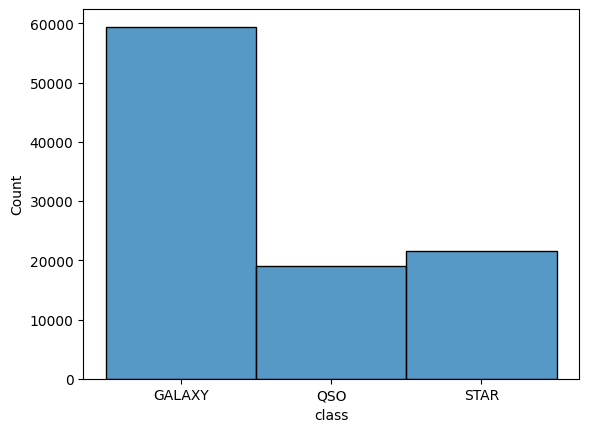

In [ ]:
import seaborn as sns

sns.histplot(df, x = "class")


For the initial classification attempt, we will be using NearestCentroid with the foresight that we have a large amount of data.

We will also be running the dataset on a normalized dataset with the mean subtracted to decrease computational effort required to process the whole set.

In [ ]:
scaler = MinMaxScaler()

df_cont = df.drop("class", axis = 1)
norm_df = pd.DataFrame(scaler.fit_transform(df_cont))

norm_df.columns = df_cont.columns

Removing ID information to prevent the model from extracting information from the names of stellar objects, and focus on the physical parameters instead to strengthen utility.

In [ ]:
phys_df = norm_df.loc[:, ~norm_df.columns.isin(["obj_ID", "run_ID", "rerun_ID", "field_ID", "spec_obj_ID", "plate", "fiber_ID", "cam_col"])]

In [ ]:
phys_df.head()

,alpha,delta,u,g,r,i,z,redshift,MJD
0,0.376905,0.503802,0.591347,0.558050,0.535344,0.427665,0.464377,0.091831,0.648007
1,0.402286,0.491812,0.632603,0.584423,0.646203,0.515986,0.607035,0.112389,0.894320
2,0.394960,0.534139,0.654888,0.576463,0.546218,0.435729,0.472194,0.093170,0.543965
3,0.940947,0.180600,0.511384,0.629186,0.596946,0.486717,0.487460,0.134210,0.878072
4,0.959118,0.392679,0.387463,0.335579,0.337999,0.287021,0.300043,0.017959,0.625205


This is the final form of the data that will be used within the analysis. We keep the class variable to the side for the moment as within the regression task we will be performing a one-hot encode on the variable to append to this dataset.

In this final iteration, it is standardized, and has most extraneous information removed.

# Classification

## Centroid and KNN Classification

Making the initial test/training split:

In [ ]:
X = phys_df
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

print(len(X_train), len(X_test))

79999 20000


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score


clf = NearestCentroid(metric = "euclidean")



model = clf.fit(X_train, y_train)

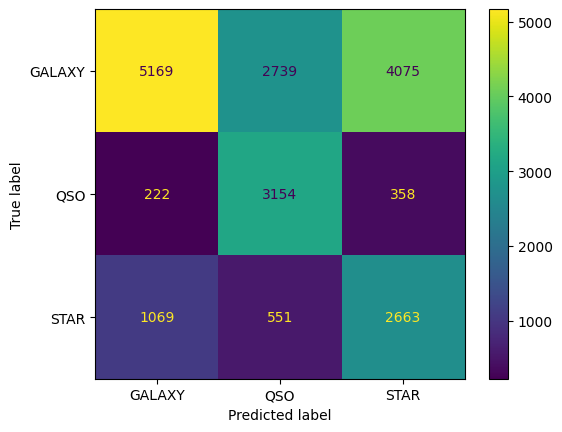

F1 Score: GALAXY 0.5605378734479206
F1 Score: QSO 0.6197681273334644
F1 Score: STAR 0.46805518938395296


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

y_hat = clf.predict(X_test)
acc = accuracy_score(y_test, y_hat)

mat = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(mat, display_labels=clf.classes_)

disp.plot()
plt.show()

f1 = f1_score(y_test, y_hat, average = None)

for ind, x in enumerate(f1):
  print("F1 Score:", clf.classes_[ind], f1[ind])

We can see from the confusion matrix that Nearest Centroid struggles with classifications other than Galaxy class, but even then it's overall performance is relatively lackluster. This is highlighted by the very low F1 score for each class within the response, indicating that we will need a different approach.

This is likely due to the simplicity of the NearestCentroid model and our next approach will pivot into KNN instead, a similiar approach but with much more resolution.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6]}

clf_neighbor = KNeighborsClassifier(metric = "euclidean")

neighbors = GridSearchCV(estimator=clf_neighbor, param_grid = param_grid, scoring = "f1_weighted", cv = 5)

neighbors.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='euclidean'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6]},
             scoring='f1_weighted')

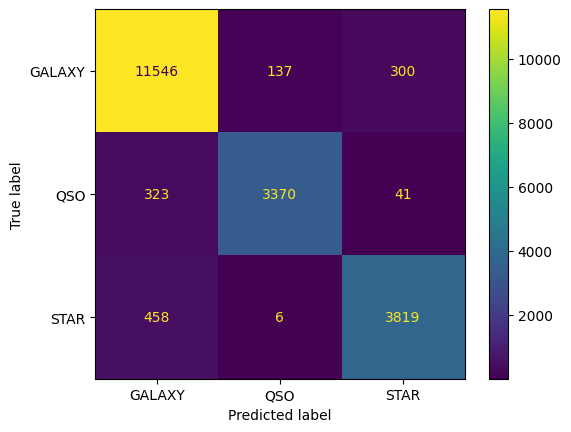

F1 Score: GALAXY 0.9498971616618674
F1 Score: QSO 0.9300400165585759
F1 Score: STAR 0.9046547435745589


In [ ]:
y_hat = neighbors.predict(X_test)
acc = accuracy_score(y_test, y_hat)

mat = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(mat, display_labels=clf.classes_)

disp.plot()
plt.show()

f1 = f1_score(y_test, y_hat, average = None)

for ind, x in enumerate(f1):
  print("F1 Score:", neighbors.classes_[ind], f1[ind])

In [ ]:
print("Best K-Value:", neighbors.best_estimator_)

Best K-Value: KNeighborsClassifier(metric='euclidean', n_neighbors=3)


For this KNN approach, we iterated through 6 different K values for the model using GridSearch, which allowed us to use a Stratified 5-Fold Cross Validation to choose the best hyperparameter for the number of neighbors while accounting for the large bias in the dataset.

We can see from our F1 Scores that this model performs significantly better than that of the Nearest Centroid, and of the two, this model should be selected.

## Naive Bayes Classification

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.91195


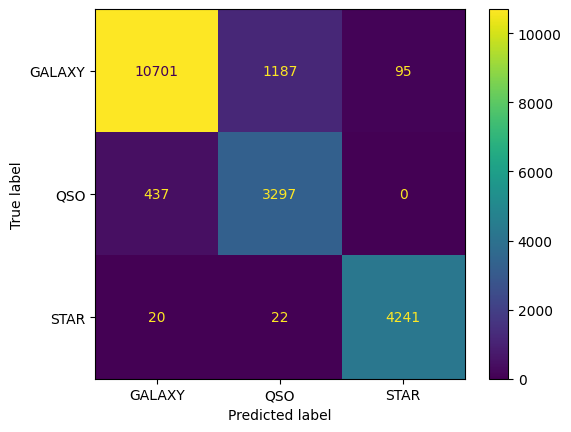

F1 Score: GALAXY 0.9248519942958385
F1 Score: QSO 0.800242718446602
F1 Score: STAR 0.9841048845573733


In [ ]:
# Naive Bayes Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

y_hat = gnb.predict(X_test)
acc = accuracy_score(y_test, y_hat)

mat = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(mat, display_labels=gnb.classes_)

disp.plot()
plt.show()

f1 = f1_score(y_test, y_hat, average = None)

for ind, x in enumerate(f1):
  print("F1 Score:", clf.classes_[ind], f1[ind])

For the Gaussian Naive Bayes classification the overall accuracy of the model performed well at 91%. This represents a pretty effective classification. The prediction accuracy of each class is good. When comparing the F1 Scores, QSO has the lowest score. This most likely is due to having the fewest datapoints in the overall dataset.

## Classification Comparison:

Between Naive Bayes and the KNN approach, we can see that there is a difference in the overall classification strength of each model. In the KNN approach, it's evident that the model performs better overall by providing consistently higher performance over all 3 classes, where as the Naive Bayes model instead spikes it's performance within the Star class, and drops some predictive performance within the Quasar class.

Between the two, it's likely that the KNN model should be chosen for it's more consistent ability to perform in the 3 levels of classification, despite NB performing very well in one of it's classification levels.

# Regression

For the regression task, we focused on building a regression model that was able to analyze and predict the **redshift** numeric value from our dataset. The nature of this regression requires that we reorient our utilized dataset, were the response switches from *Class* to *RedShift*.

This switch allows us to use the class variable as a categorical feature to fit into our model to build a more robust regression. This is accomplished by utilizing One Hot Encoding on our categorical variable to create dummy variables and encode our categorical variable in such a way that the model can utilize it's information.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

phys_enc = phys_df.join(df["class"])

OHE = OneHotEncoder(sparse_output = False)

classes = phys_enc["class"].values.reshape(-1,1)

transform = pd.DataFrame(OHE.fit_transform(classes), columns = OHE.get_feature_names_out())
transform = transform.drop("x0_nan", axis=1)

phys_enc = phys_enc.drop("class", axis = 1)
phys_enc = phys_enc.join(transform)


In [ ]:
phys_enc.head()

,alpha,delta,u,g,r,i,z,redshift,MJD,x0_GALAXY,x0_QSO,x0_STAR
0,0.376905,0.503802,0.591347,0.558050,0.535344,0.427665,0.464377,0.091831,0.648007,1.0,0.0,0.0
1,0.402286,0.491812,0.632603,0.584423,0.646203,0.515986,0.607035,0.112389,0.894320,1.0,0.0,0.0
2,0.394960,0.534139,0.654888,0.576463,0.546218,0.435729,0.472194,0.093170,0.543965,1.0,0.0,0.0
3,0.940947,0.180600,0.511384,0.629186,0.596946,0.486717,0.487460,0.134210,0.878072,1.0,0.0,0.0
4,0.959118,0.392679,0.387463,0.335579,0.337999,0.287021,0.300043,0.017959,0.625205,1.0,0.0,0.0


We can see the one hot encoded variables added to the end of dataset above.

Our initial data is scaled, but it's important that our encoded variables are added after the fact, since they are representative of the classes and scaling them will remove the representation of the classes in the data.

In [ ]:
X = phys_enc.drop("redshift", axis=1)
y = phys_df["redshift"]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [ ]:
print(len(Xr_train), len(Xr_test))

79999 20000


## Linear Regression

In [74]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

X = Xr_train
y = yr_train

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
yr_hat = lm.predict(Xr_test)

mse = mean_squared_error(yr_test, yr_hat)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.005079356181786043


## LinearSVR Regression

In [76]:
from sklearn.svm import LinearSVR

X = Xr_train
y = yr_train

param_grid = {'C': [0.7, 0.75, 0.8, 0.85, 0.9, 1]}

SVR = LinearSVR(loss = "squared_epsilon_insensitive", dual=False)
SVR.fit(X, y)
yr_hat = SVR.predict(Xr_test)

svr_grid = GridSearchCV(estimator = SVR, param_grid = param_grid, scoring= "neg_mean_squared_error", cv = 5)
svr_grid.fit(X,y)
svr_hat = svr_grid.predict(Xr_test)

mse = mean_squared_error(yr_test, svr_hat)
print("Best Parameters:", svr_grid.best_estimator_)
print("Grid Searched Mean Squared Error:", mse)

Best Parameters: LinearSVR(C=0.8, dual=False, loss='squared_epsilon_insensitive')
Grid Searched Mean Squared Error: 0.005079655606642888


## Regression Analysis

In [73]:
coefficients = pd.concat([pd.DataFrame(Xr_train.columns),pd.DataFrame(np.transpose(svr_grid.best_estimator_.coef_))], axis = 1)
print("LinearSVR Coeffecients")
coefficients

LinearSVR Coeffecients


,0,0
0,alpha,-0.000247
1,delta,-0.002914
2,u,0.020187
3,g,-0.136892
4,r,0.056279
5,i,0.363870
6,z,0.064338
7,MJD,0.033951
8,x0_GALAXY,-0.044381
9,x0_QSO,0.075700


We can pick out some interesting relationships from these regression coeffecients, namely physical phenomena that can be explained by some intuition. We can see that as redshift increases (or the distance of each stellar object increases from us) that the luminosity of the red/infrared wavelength increases and green wavelengths decrease, which mirrors what we intuitively expect from the Doppler shifts in wavelengths.

Additionally we see that as redshift increases, we see less Galaxies and Stars, and more Quasars, which also makes sense given that Quasars are some of the brightest objects in a stellar scan, often regardless of distance.

## Regression Comparison

For our Regression task, we utilized 2 regression models, one Linear Regression as a baseline, and a Linear Support Vector Regression with a Stratified 5 Fold Grid Search to identify relevant hyper parameters. As with the classification task, the cross-validation methods here are stratified because it maintains the ratios of class variables within each "fold" of the data.

These models were trained on an 80/20 train/test split of the initial data that had been scaled and had it's categorical variable one-hot encoded to allow it to be utilized within the Linear and LinearSVR models.


Between these two models, we utilized the MSE as a method of determining modelling strength as F1 score from the classification task is not relevant to this model.  We can see from the MSE scores of each that their performance on the test set was remarkably close as might require further investigation to determine which model should be used for the task.

It's likely that these models are operating very similarly because our dataset itself is wholly numerical and standardized which distills any regression tasks to very ideal scenarios.

# Variable Importance

With a previous utilization of PCR and Logistic Regression, we found that most of the ID variables within the dataset did not have a statistically significant impact in explaining the overall variance within the dataset and didn't provide much info in classification, respectively. Using this insight, we could safely remove this data from the dataset, knowing that most of our variance and information lay in the physical properties of each stellar object.

The removal of the IDs also removed any possiblity of models misassociating a naming schema with the classification task. This could effectively let the model cheat, as if certain ID groups were associated with any classification tags, that information might skew any of the physical properties in the other variables.

We standardized the data to optimize any distance calculations and speed up any of the more complex models, due to the large size of the dataset. We also rationalized this standarization with the foresight that SVR ideally the best on standardized data.

# Deployment

The utility of these tools exists mainly for research and potentially to be used on datasets even larger than the one that was introduced to train these models. The utility of an autonomous classifier is highlighted when the scope of newer and larger stellar surveys are taken into consideration. The ability to observe any stellar object and have it's object classification streamlines the collection and aggregation of data, and could potentially be used to data mine stronger and more robust classifiers in the future. How these physical observations are collected and analyzed are beyond the scope of the assignment.

As the models implementation increase in scope, the classification rate will need to be revised to more robust values as while the current misclassification rate is acceptable at lower sample sizes, at samples >100k, the misclassification amount could possibly balloon to unacceptable sizes. Whether or not these misclassifications are statistically relevant in the grandscheme of an analysis depends on the use case and tolerance of the user.